# Become a Kaggle Master-HW3
This competition is a classification exercise. You are called upon to help the economic team of a leading consulting firm. The objective of the competition is to determine the economic regime predicted by the best economists for the emerging world compared to the rest of the world. Economists have identified 3 regimes for emerging countries versus the rest of the world:
* 1: growing faster
* 0: similar pace
* -1: slower

Réalisé par Team ZYMMA :
- AYARI Mohamed Aziz
- YBEGGAZENE Zakaria

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('train.csv', parse_dates=['Date'])
test = pd.read_csv('test.csv', parse_dates=['Date'])

In [3]:
df = pd.concat([train, test], ignore_index=True)

## Check unbalanced data

In [4]:
# Compute the class distribution of the target variable
class_dist = train['Market_Regime'].value_counts(normalize=True)
print(class_dist)

 1    0.364577
 0    0.363427
-1    0.271995
Name: Market_Regime, dtype: float64


## Dataviz

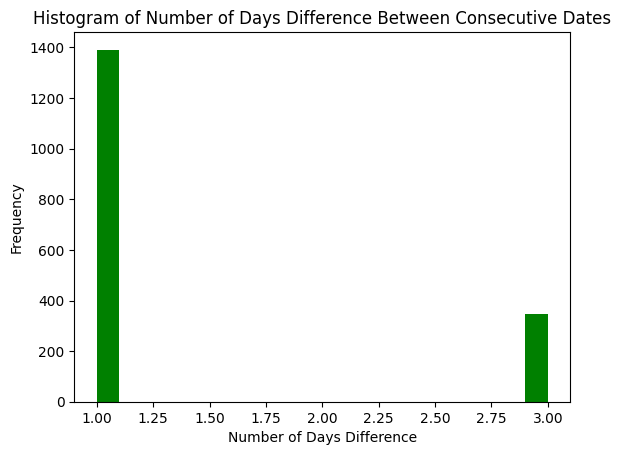

In [5]:
# Convert the date column to a datetime data type
train['Date'] = pd.to_datetime(train['Date'])

# Calculate the time difference between consecutive dates
time_diff = train['Date'].diff()

# Convert time deltas to integer number of days
days_diff = time_diff.dt.days

# Plot the number of days difference between consecutive dates as a histogram
plt.hist(days_diff, bins=20, color='green')
plt.xlabel('Number of Days Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Days Difference Between Consecutive Dates')
plt.show()

Text(0.5, 1.0, 'Pie Chart for distribution of target')

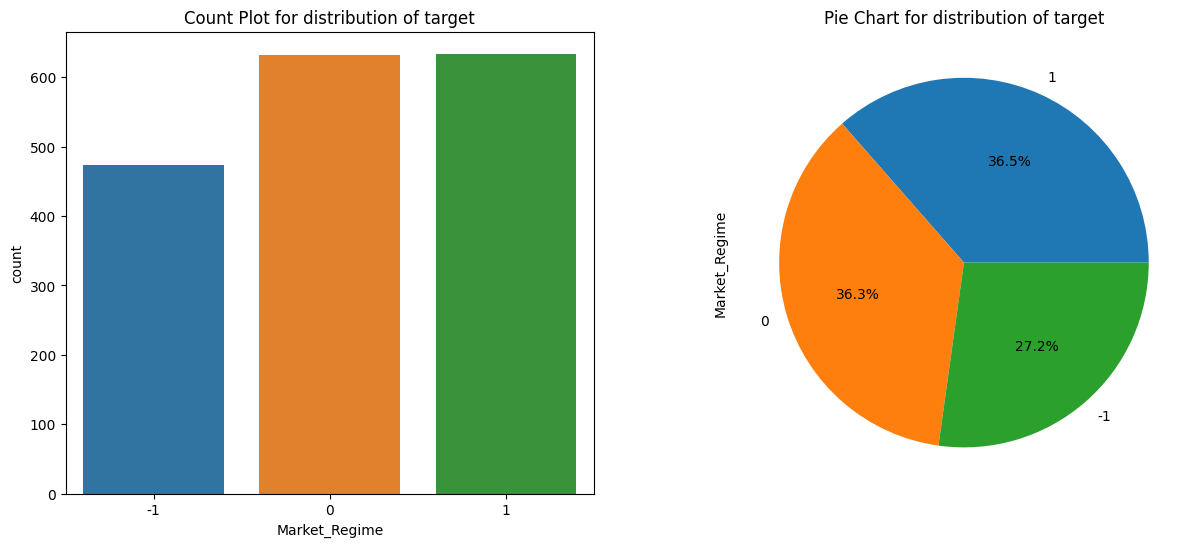

In [6]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
_ = sns.countplot(x='Market_Regime', data=train, ax=ax[0])
_ = train['Market_Regime'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])
ax[0].set_title('Count Plot for distribution of target')
ax[1].set_title('Pie Chart for distribution of target')

## Feature engineering

In [7]:
from sklearn.preprocessing import LabelEncoder
# Define the rolling window size for rolling average
window_size = 7

# Calculate rolling average for each column except 'Date' and 'Market_Regime'
for col in df.columns:
    if col not in ['Date','Market_Regime'] :
        df[col + '_RollingAvg'] = df[col].rolling(window=window_size).mean()

# Calculate rolling average for each column except 'Date' and 'Market_Regime'
for col in df.columns:
    if col not in ['Date','Market_Regime'] :
        df[col + '_RollingAvg'] = df[col].rolling(window=15).mean()

# Create lag features
lag_periods = [1,3,5,10]  # You can adjust the lag periods as needed
for col in df.columns:    
        for lag in lag_periods:
            df[col + '_Lag' + str(lag)] = df[col].shift(lag)


<ipython-input-7-67cf38caa115>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_Lag' + str(lag)] = df[col].shift(lag)
<ipython-input-7-67cf38caa115>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_Lag' + str(lag)] = df[col].shift(lag)
<ipython-input-7-67cf38caa115>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

In [8]:
# Converting to datetime datatype
df['Date'] = pd.to_datetime(df['Date'])
#Add new features such as year month and semester
df['Date_year'] = df['Date'].dt.year
df['Date_month'] = df['Date'].dt.month
df['Date_day'] = df['Date'].dt.day
df['Date_dow'] = df['Date'].dt.dayofweek
df['Date_week'] = df['Date'].dt.week
df['quarter'] = df['Date'].dt.quarter
df['semester'] = np.where(df['quarter'].isin([1,2]), 1, 2)

<ipython-input-8-2852b6482d41>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Date_year'] = df['Date'].dt.year
<ipython-input-8-2852b6482d41>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Date_month'] = df['Date'].dt.month
<ipython-input-8-2852b6482d41>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

In [9]:
df.dtypes.value_counts()

float64           380
int64               7
datetime64[ns]      5
dtype: int64

<ipython-input-10-a4be403e0725>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


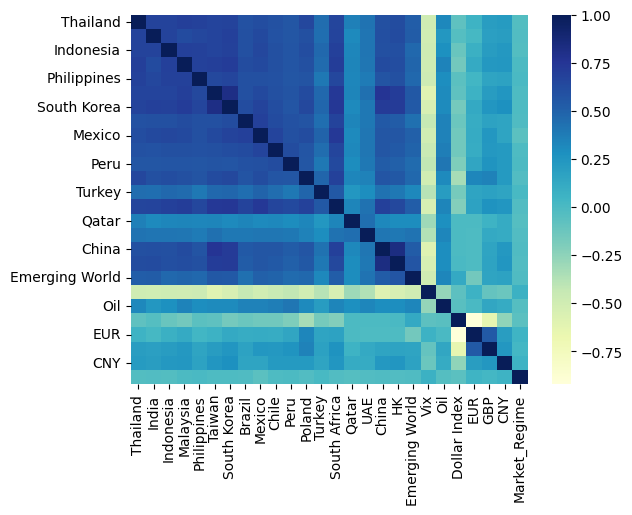

In [10]:
corr_matrix = train.corr()
# Visualize the correlation matrix using a heatmap
import seaborn as sns
sns.heatmap(corr_matrix, cmap="YlGnBu")
# Set a correlation threshold
corr_threshold = 0.7
# Identify highly correlated variables
highly_correlated = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            highly_correlated.add(colname)

In [11]:
df = df.drop(columns=highly_correlated)

### Separate dataset

In [12]:
# Separate the data back into the original training and testing sets
train_df = df.iloc[:len(train)]
test_df = df.iloc[len(train):]

In [13]:
# Encode the target variable
label_encoder = LabelEncoder()
train_df['Market_Regime'] = label_encoder.fit_transform(train_df['Market_Regime'])

<ipython-input-13-2aed392185b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Market_Regime'] = label_encoder.fit_transform(train_df['Market_Regime'])


In [14]:
train_df = train_df.dropna()

### Split data

In [15]:
from imblearn.over_sampling import SMOTE
# Split the data into features (X) and target variable (y)
X_df = train_df.drop(['Date', 'Market_Regime'], axis=1)
y_df = train_df['Market_Regime']

In [16]:
#smote for umbalanced data
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X_df, y_df)

TypeError: ignored

# Modeling

## Logistic Regression + RandomizedSearchCV + KFold

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Encode the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)


# Define the hyperparameter grid for randomized search
hyperparameter_grid = {
    'C': [0.1, 1, 10],
    'tol': [1e-4, 1e-3, 1e-2],
    'max_iter': [100, 500, 1000]
}

# Build the logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Perform randomized grid search with k-fold cross-validation
randomized_search = RandomizedSearchCV(model, hyperparameter_grid, n_iter=10, scoring='roc_auc_ovr', n_jobs=-1, cv=KFold(n_splits=5, shuffle=False))
randomized_search.fit(X_train, y_train_encoded)

# Print the best hyperparameters found by randomized search
print('Best hyperparameters:', randomized_search.best_params_)

# Evaluate the best model found by randomized search using AUC-ROC
best_model_reg = randomized_search.best_estimator_
y_pred_proba = best_model_reg.predict_proba(X_val)
auc_roc = roc_auc_score(y_val_encoded, y_pred_proba, multi_class='ovr')
print('AUC-ROC:', auc_roc)

Best hyperparameters: {'tol': 0.0001, 'max_iter': 1000, 'C': 1}
AUC-ROC: 0.5643186010127


## Random forest + KFold + GS

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import pandas as pd

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score




# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=False)

# Initialize an empty list to store the AUC scores
auc_scores = []

# Loop over the folds
for train_index, test_index in kf.split(X_scaled):
    # Split the data into training and testing sets
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize the model
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict the probabilities of the target classes for the test set
    y_pred_proba = model.predict_proba(X_test)

    # Compute the AUC score for the test set
    auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    auc_scores.append(auc_score)

# Print the mean AUC score and standard deviation over the folds
print(f"Mean AUC: {np.mean(auc_scores):.3f}")
print(f"Standard deviation: {np.std(auc_scores):.3f}")


Mean AUC: 0.562
Standard deviation: 0.080


## XGBoost + RandomizedGS + CV 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder


# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

#Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 3, 
#'max_depth': 9, 'learning_rate': 0.3, 'gamma': 1, 'colsample_bytree': 0.7}
param_dist = {
    'n_estimators': [100],
    'learning_rate': [0.3],
    'max_depth': [9],
    'gamma': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
    'min_child_weight': [3]
}

# Perform GridSearchCV
random_search  = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100,
                                   scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Train the best model
best_model.fit(X_train, y_train)

# Predict class probabilities on the test set
y_pred_proba = best_model.predict_proba(X_test)

# Calculate AUC score for each class
class_auc_scores = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average="weighted")

# Calculate average AUC score
auc_score = np.mean(class_auc_scores)
print('AUC Score:', auc_score)
print('Best Parameters:', best_params)

AUC Score: 0.8938525297909757
Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 1, 'colsample_bytree': 0.7}


## Random forest + KFold + RandomizedGS

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

#Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with k-fold cross-validation
clf = RandomForestClassifier(random_state=42)
grid_search = RandomizedSearchCV(clf, param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

# Print the best parameters and mean cross-validated score
print('Best parameters:', grid_search.best_params_)
print('Mean cross-validated score:', grid_search.best_score_)

# Fit the model with the best hyperparameters on the entire dataset
clf_random = RandomForestClassifier(random_state=42, **grid_search.best_params_)
clf_random.fit(X, y)
# Predict the probabilities of the target classes for the test set
y_pred_proba = clf_random.predict_proba(X_test)

# Get the predicted class labels
y_pred = clf_random.predict(X_test)

# Compute the AUC score for the test set
auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
auc_scores.append(auc_score)

# Print the mean AUC score and standard deviation over the folds
print(f"Mean AUC: {np.mean(auc_scores):.3f}")
print(f"Standard deviation: {np.std(auc_scores):.3f}")

Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}
Mean cross-validated score: nan
Mean AUC: 0.627
Standard deviation: 0.161


## XGBoost Cross-Validation with TimeSeriesSplit (and multi:softmax objective)

In [20]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_val_predict
import xgboost as xgb

In [ ]:
# Obtained params with GridSearchCV
params = {'colsample_bytree': 0.8,
          'gamma': 0,
          'learning_rate': 0.1,
          'max_depth': 6,
          'n_estimators': 100}

# Create an instance of TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)  # specify the number of splits as needed

# Create an instance of XGBClassifier for multi-class classification
xgb_1 = xgb.XGBClassifier(params, objective='multi:softmax', eval_metric='auc', num_class=3)

# Perform time series cross-validation with ROC AUC as the evaluation metric
roc_auc_scores = cross_val_score(xgb_1, X, y, cv=tscv, scoring='roc_auc_ovr')

# Calculate and print the average ROC AUC score
average_roc_auc = np.mean(roc_auc_scores)
print('Average ROC AUC:', average_roc_auc)

## XGBoost Cross-Validation with TimeSeriesSplit (and custom ROC AUC objective)

In [22]:
def roc_auc_obj(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds)) # convert predictions to probabilities
    grad = preds - labels
    hess = preds * (1.0 - preds)
    return grad, hess

In [ ]:
# Obtained params with GridSearchCV
params = {'colsample_bytree': 0.8,
          'gamma': 0,
          'learning_rate': 0.1,
          'max_depth': 3,
          'n_estimators': 150}

# Create an instance of TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # specify the number of splits as needed

# Create an instance of XGBClassifier for multi-class classification
xgb_2 = xgb.XGBClassifier(params, objective=roc_auc_obj, eval_metric='auc', num_class=3)

# Perform time series cross-validation with ROC AUC as the evaluation metric
roc_auc_scores = cross_val_score(xgb_2, X, y, cv=tscv, scoring='roc_auc_ovr')

# Calculate and print the average ROC AUC score
average_roc_auc = np.mean(roc_auc_scores)
print('Average ROC AUC:', average_roc_auc)

## RandomForrest Cross-Validation with TimeSeriesSplit

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Obtained params with GridSearchCV
params = {'max_features': 0.8,
          'n_estimators': 50}

# Create an instance of TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)  # specify the number of splits as needed

# Create an instance of RandomForestClassifier for multi-class classification
rf_1 = RandomForestClassifier(**params)

# Perform time series cross-validation with ROC AUC as the evaluation metric
roc_auc_scores = cross_val_score(rf_1, X, y, cv=tscv, scoring='roc_auc_ovr')

# Calculate and print the average ROC AUC score
average_roc_auc = np.mean(roc_auc_scores)
print('Average ROC AUC:', average_roc_auc)

## Averaging Cross-Validation with TimeSeriesSplit

In [ ]:
params = {'colsample_bytree': 0.8,
          'gamma': 0,
          'learning_rate': 0.1,
          'max_depth': 3,
          'n_estimators': 150}
xgb_3 = xgb.XGBClassifier(params, objective='multi:softmax', eval_metric='auc', num_class=3)
params = {'max_features': 0.8,
          'n_estimators': 50}
rf_2 = RandomForestClassifier(**params)

In [ ]:
# Create a TimeSeriesSplit object for cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Choose the number of splits as needed

# Initialize lists to store predictions from each split
rf_predictions = []
xgb_predictions = []

# Loop through each split in TimeSeriesSplit
for train_index, test_index in tscv.split(X_train):
    # Split the data into train and test sets based on current split
    X_train_, X_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_, y_test = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the random forest model
    rf_2.fit(X_train_, y_train_)
    # Make predictions on the test set
    rf_pred = rf_2.predict_proba(X_test)
    # Append the predictions to the list
    rf_predictions.append(rf_pred)

    # Train the xgboost model
    xgb_3.fit(X_train_, y_train_)
    # Make predictions on the test set
    xgb_pred = xgb_3.predict_proba(X_test)
    # Append the predictions to the list
    xgb_predictions.append(xgb_pred)

# Concatenate the predictions from all splits vertically
rf_predictions = np.concatenate(rf_predictions)
xgb_predictions = np.concatenate(xgb_predictions)

# Perform majority voting on the predictions
ensemble_predictions = np.argmax((rf_predictions + xgb_predictions) / 2, axis=1)

In [ ]:
# Calculate the ROC AUC score for each class separately
roc_auc_scores = []
for i in range(y.max() + 1):  # assuming classes are encoded as [0, 1, 2, ...]
    y_one_hot = (y == i).astype(int)
    ensemble_pred_one_hot = (ensemble_predictions == i).astype(int)
    roc_auc = roc_auc_score(y_one_hot, ensemble_pred_one_hot)
    roc_auc_scores.append(roc_auc)

print("ROC AUC scores for each class: {}".format(roc_auc_scores))

## Test

In [ ]:
test_df=test_df.drop(['Date','Market_Regime'], axis=1)


**XGBoost prediction**

In [ ]:
# Predict the probabilities of the target classes for the test set
preds = best_model.predict(test_df)
y_pred = np.where(preds == 0, -1, np.where(preds == 1, 0, 1))

**Models prediciton**

In [ ]:
# Predict the probabilities of the target classes for the test set
y_pred_proba = clf_random.predict_proba(test_df)
# Get the predicted class labels
y_pred_grid = clf_random.predict(test_df)

**Ensemble method**

In [ ]:
models=[best_model,clf_random]

In [ ]:
def ensemble_voting(models, X_test):
    # Make predictions on the test set using each model
    predictions = []
    for model in models:
        y_pred = model.predict(X_test)
        predictions.append(y_pred)
        
    # Compute the majority vote for each test instance
    predictions = np.array(predictions)
    y_test_predicted = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
    
    return y_test_predicted


In [ ]:
y_pred_voting=ensemble_voting(models, test_df)

**Decode labels**

In [ ]:
y_test_predicted_decoded = label_encoder.inverse_transform(y_pred_voting)
y_test_predicted_decoded=y_test_predicted_decoded.astype(int)

In [ ]:
solution = pd.DataFrame({"Date":test.Date, "Market_Regime":y_test_predicted_decoded})
solution.to_csv("submission_kaggle_Final_voting.csv", index = False)